## Topic Modeling Using Twitter and LDA

### Step 1: API setup

In [1]:
# Import Libraries
import tweepy as tw
import pandas as pd
pd.set_option("display.max_colwidth", 500)

In [2]:
# Setting twitter access tokens

# Variables that contain the user credential to access twitter API
ACCESS_TOKEN = 
ACCESS_TOKEN_SECRET = 
CONSUMER_API_KEY = 
CONSUMER_API_SECRET = 

# create an authentication object
auth = tw.OAuthHandler(CONSUMER_API_KEY, CONSUMER_API_SECRET)

# Setting your access token and secret
auth.set_access_token(ACCESS_TOKEN,ACCESS_TOKEN_SECRET)

# Create the API object passing the auth object
api = tw.API(auth, wait_on_rate_limit=True)

### Step 2: Data Collection

In [3]:
# Define parameters for extracting user timeline
account = "CityNews"
tweets = []  
result = api.user_timeline(id=account,
                           count=200,
                           include_rts = False,
                           tweet_mode="extended")
    
tweets.extend(result) 
oldest = tweets[-1].id - 1
    
# Continue fetching tweets until max is reached
while len(result) > 0:
    result = api.user_timeline(id=account,
                               count=200,
                               include_rts = False,
                               tweet_mode="extended",
                               max_id=oldest)
        
    # Save most recent tweets
    tweets.extend(result)
        
    # Update the id of the oldest tweet less one
    oldest = tweets[-1].id - 1
    print(f"Fetched {len(tweets)} tweets...")
    
# Export all tweets to list
all_tweets = [[i.full_text] for i in tweets]

# Create dataframe with for all tweets
df = pd.DataFrame(all_tweets , columns=['Tweets'])
df.to_csv('tweets.csv', index=False)

Fetched 337 tweets...
Fetched 496 tweets...
Fetched 656 tweets...
Fetched 821 tweets...
Fetched 973 tweets...
Fetched 1116 tweets...
Fetched 1246 tweets...
Fetched 1391 tweets...
Fetched 1537 tweets...
Fetched 1683 tweets...
Fetched 1829 tweets...
Fetched 1960 tweets...
Fetched 2114 tweets...
Fetched 2258 tweets...
Fetched 2400 tweets...
Fetched 2437 tweets...
Fetched 2437 tweets...


In [4]:
df.shape

(2437, 1)

### Step 3: Data Cleaning

In [5]:
# Import libraries
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

In [6]:
# Import tweet.csv
df_tweets = pd.read_csv('tweets.csv')

# Drop duplicate rows
df_tweets.drop_duplicates(subset='Tweets',inplace=True)

# Function for dropping na values
def drop_na(col):
    df_tweets.dropna(inplace=True)
    df_tweets.drop(df_tweets[df_tweets[col] == ''].index, inplace=True)
    df_tweets.reset_index(drop=True, inplace=True)

# Remove links, non-alpha numeric characters, stopwords and lemmatize each words
drop_na('Tweets')
stop = set().union(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
df_tweets['Clean_Tweets'] = df_tweets['Tweets'].str.lower()\
                             .apply(lambda x: re.split('https:\/\/.*', str(x))[0])\
                             .str.replace(r'[^a-zA-Z ]\s?',r' ',regex=True)\
                             .apply(lambda words: [item for item in words.split() if item not in stop and len(item) > 3])\
                             .apply(lambda words: [lemmatizer.lemmatize(item) for item in words])
drop_na('Clean_Tweets')

In [7]:
df_tweets.sample(5)

,Tweets,Clean_Tweets
1541,"#BREAKING: Superintendent Ron Taverner says the shooting occurred at an outdoor birthday party for a 1-year-old. An 11-year-old boy, a 5-year-old girl and a 23-year-old male were shot. A 1-year-old was grazed by gunshot.","[breaking, superintendent, taverner, say, shooting, occurred, outdoor, birthday, party, year, year, year, girl, year, male, shot, year, grazed, gunshot]"
1889,A Toronto man says he was followed by a group of men who taunted him with homophobic slurs before beating him “nearly to death” on Hanlan's Point over the weekend.\nhttps://t.co/MyTEFFF4Th,"[toronto, say, followed, group, taunted, homophobic, slur, beating, nearly, death, hanlan, point, weekend]"
1523,"Quebec's Culture Minister says only music by provincial artists will be played in government buildings and on phone lines, with particular emphasis on French-language performers https://t.co/4O62tpQGkq","[quebec, culture, minister, say, music, provincial, artist, played, government, building, phone, line, particular, emphasis, french, language, performer]"
2282,Should post-secondary students be required to get their COVID-19 shot before heading back to campus? Faiza Amin finds out whether universities and colleges in and around the GTA will be mandating vaccinations. https://t.co/VxiLdRpcBT,"[post, secondary, student, required, covid, shot, heading, back, campus, faiza, amin, find, whether, university, college, around, mandating, vaccination]"
370,"Are you a parent, student or teacher with questions about school air quality/building safety? Here's your chance to ask. Public health design expert Jeffrey Siegel will answer on July 26, 2:30 p.m. in a LIVE Q&amp;A. Submit using #COVIDquestions or click here https://t.co/n1aTK4uIeW https://t.co/J8b45ZAkqh","[parent, student, teacher, question, school, quality, building, safety, chance, public, health, design, expert, jeffrey, siegel, answer, july, live, submit, using, covidquestions, click]"


### Step 4: Topic Modelling

In [8]:
# Import libraries
import gensim
from gensim import corpora, models
from pprint import pprint

#### Bag of words

In [9]:
# Create a dictionary from df_tweets Clean_Text with the number of times a word appears in datset.
clean_text = df_tweets.Clean_Tweets
dictionary = gensim.corpora.Dictionary(clean_text)

# Filter out tokens that appear in less than 15 documents or more than 1 documents 
# Then, keep only the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=1, keep_n=100000)

# Gensim doc2bow (document to bag of words)
# For each document we create a dictionary reporting how many
# words and how many times those words appear. Save this to 'bow_corpus'
bow_corpus = [dictionary.doc2bow(doc) for doc in clean_text]

In [10]:
# Sample record for checking
bow_doc_945 = bow_corpus[945]
for i in range(len(bow_doc_945)):
    print("Word {} \"{}\" appears {} time.".format(bow_doc_945[i][0], 
                                               dictionary[bow_doc_945[i][0]], bow_doc_945[i][1]))

Word 7 "covid" appears 1 time.
Word 11 "plan" appears 1 time.
Word 56 "toronto" appears 1 time.
Word 82 "including" appears 1 time.
Word 87 "business" appears 1 time.
Word 94 "pandemic" appears 1 time.
Word 107 "city" appears 1 time.
Word 129 "clinic" appears 1 time.
Word 163 "help" appears 1 time.
Word 181 "vaccination" appears 1 time.
Word 229 "delta" appears 1 time.
Word 231 "variant" appears 1 time.
Word 279 "headline" appears 2 time.
Word 282 "morning" appears 2 time.
Word 391 "downtown" appears 1 time.


#### TF-IDF Model

In [11]:
# Create tf-idf model object using models.TfidfModel on 'bow_corpus' and save it to 'tfidf'.
# Then, apply transformation to the entire corpus and call it 'corpus_tfidf'. 
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# Preview TF-IDF scores for the first document.
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.359832492026061),
 (1, 0.3035463065668299),
 (2, 0.36563523149067845),
 (3, 0.719664984052122),
 (4, 0.1762854883233477),
 (5, 0.3093490460314474)]


#### Apply LDA on TF-IDF data

In [12]:
# Train our lda model using gensim.models.LdaMulticore and save it to 'lda_model_tfidf'
# Set 15 topics
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary)

# For each topic, print the keywords and its relative weight.
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.016*"covid" + 0.016*"canada" + 0.014*"toronto" + 0.014*"health" + 0.013*"live" + 0.012*"update" + 0.011*"watch" + 0.011*"today" + 0.010*"vaccine" + 0.010*"canadian"

Topic: 1 
Words: 0.018*"watch" + 0.017*"covid" + 0.016*"live" + 0.015*"update" + 0.013*"toronto" + 0.013*"people" + 0.012*"official" + 0.011*"breaking" + 0.010*"rate" + 0.010*"canada"

Topic: 2 
Words: 0.018*"breaking" + 0.016*"toronto" + 0.015*"year" + 0.011*"canada" + 0.010*"thebigstoryfpn" + 0.010*"police" + 0.010*"blue" + 0.009*"expert" + 0.009*"government" + 0.009*"covid"

Topic: 3 
Words: 0.013*"update" + 0.013*"police" + 0.012*"toronto" + 0.012*"people" + 0.011*"covid" + 0.011*"around" + 0.009*"tory" + 0.009*"sunday" + 0.009*"canada" + 0.008*"john"

Topic: 4 
Words: 0.014*"covid" + 0.013*"ontario" + 0.013*"toronto" + 0.010*"school" + 0.009*"child" + 0.009*"health" + 0.009*"government" + 0.009*"week" + 0.009*"home" + 0.008*"update"

Topic: 5 
Words: 0.021*"update" + 0.013*"year" + 0.013*"health" + 

### Step 5: Plot the Top 5 topics

In [13]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Topic, Keywords and its Contribution/Weight to each tweet

In [14]:
# Define variables
model = lda_model_tfidf
corpus = corpus_tfidf
text = df_tweets.Tweets

# Initialize topics_df
df_topics = pd.DataFrame()

# Run for loop to determine the dominant topic number for each tweet
for i, row in enumerate(model[corpus]): # getting main topics per element
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, cont) in enumerate(row): 
        if j == 0:  # => dominant topic
            wp = model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            df_topics = df_topics.append(pd.Series([str(topic_num), topic_keywords, round(cont,4)]), 
                                         ignore_index=True)
        else:
            break

# Define column names            
df_topics.columns = ['Topic', 'Keywords', 'Contribution']

# Add original text/tweets to the end of the output
df_topics = pd.concat([pd.Series(text), df_topics], axis=1)

In [15]:
df_topics.sample(3)

,Tweets,Topic,Keywords,Contribution
1596,Parliamentary committee calls for a freeze on all promotions and salary increases for the military’s top brass until they can be screened for past incidents of inappropriate behaviour https://t.co/GbHK4jwDsc,1,"watch, covid, live, update, toronto, people, official, breaking, rate, canada",0.5152
1500,#BREAKING: Canada easing travel quarantine restrictions for fully vaccinated passengers as of July 5 https://t.co/JXTpidfiwX,8,"vaccine, covid, toronto, july, vehicle, canada, million, update, ontario, friday",0.7398
2410,"Prime Minister Justin Trudeau has condemned the Belarusian government’s recent seizure of a dissident journalist on board an intercepted airliner, saying Canada is weighing measures beyond current sanctions against the country. https://t.co/rXCADnEoMd",12,"today, update, prime, minister, canadian, dead, vaccine, covid, year, first",0.6717


#### Top 5 topics based on dominance to whole document

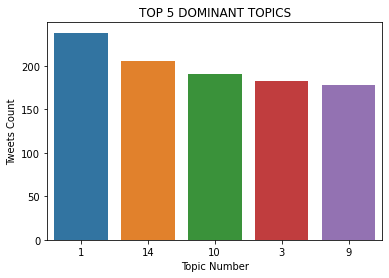

,Topic,Keywords,Count
0,1,"watch, covid, live, update, toronto, people, official, breaking, rate, canada",238
1,14,"ontario, government, report, year, canadian, million, covid, saturday, detail, question",205
2,10,"school, police, live, watch, update, injury, year, minister, child, people",191
3,3,"update, police, toronto, people, covid, around, tory, sunday, canada, john",183
4,9,"canada, breaking, say, covid, sunday, police, ontario, update, week, group",178


In [16]:
# Create dataframe for top 5 dominant topics
keywords = pd.DataFrame(df_topics.groupby(['Topic', 'Keywords']).size().reset_index(name='Count'))
top5_bycount = keywords.sort_values(by='Count', ascending=False)[:5]
top5_bycount.reset_index(drop=True, inplace=True)

# Generate bar plot
plt.figure(figsize=(6,4))
sns.barplot(x='Topic', y='Count', data=top5_bycount)
plt.title("TOP 5 DOMINANT TOPICS")
plt.ylabel("Tweets Count")
plt.xlabel("Topic Number")
plt.show()
top5_bycount

#### Top 5 topics based on the average Contribution or weight to the whole document

<Figure size 432x288 with 0 Axes>

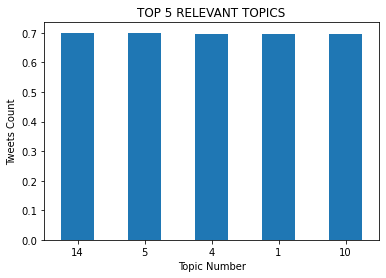

,Topic,Keywords,Contribution mean
6,14,"ontario, government, report, year, canadian, million, covid, saturday, detail, question",0.700718
10,5,"update, year, health, covid, question, live, police, toronto, vaccine, coronavirus",0.698802
9,4,"covid, ontario, toronto, school, child, health, government, week, home, update",0.697713
1,1,"watch, covid, live, update, toronto, people, official, breaking, rate, canada",0.695876
2,10,"school, police, live, watch, update, injury, year, minister, child, people",0.695876


In [17]:
# Generate bar plot
plt.figure(figsize=(6,4))
x = (df_topics.groupby(['Topic']).agg(['mean'])).apply(lambda x: x.sort_values(ascending=False).head())
x.plot.bar(legend=None)
plt.xticks(rotation=0)
plt.title("TOP 5 RELEVANT TOPICS")
plt.ylabel("Tweets Count")
plt.xlabel("Topic Number")
plt.show()

# Generate the table
top5_byweight = df_topics.groupby(['Topic', 'Keywords'], as_index=False).agg({'Contribution':['mean']})
top5_byweight.columns = list(map(' '.join, top5_byweight.columns.values))
top5_byweight = top5_byweight.sort_values(by='Contribution mean', ascending=False)[:5]
top5_byweight = pd.DataFrame(top5_byweight)
top5_byweight

### Step 6: Generate Wordcloud for each Topic

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

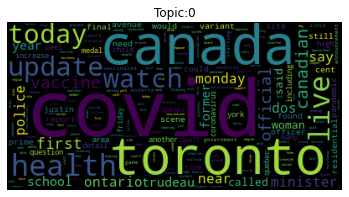

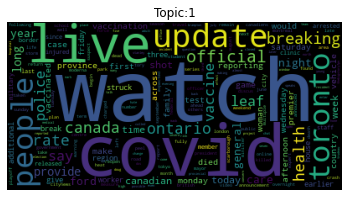

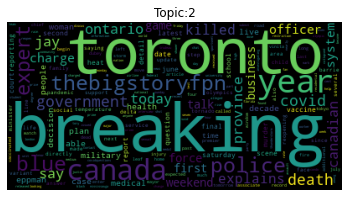

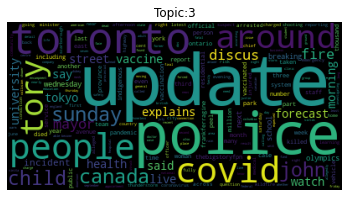

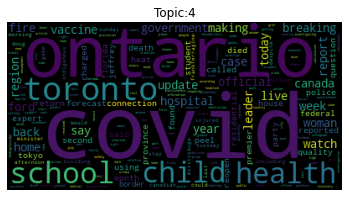

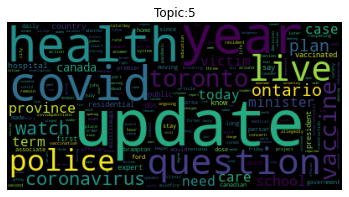

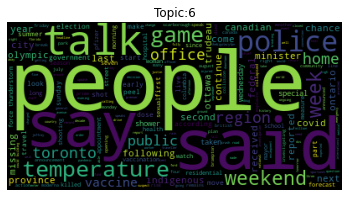

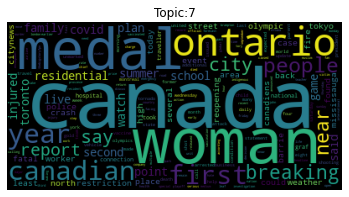

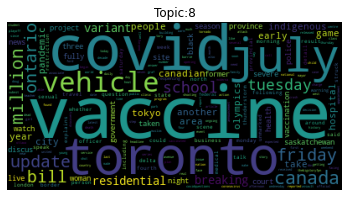

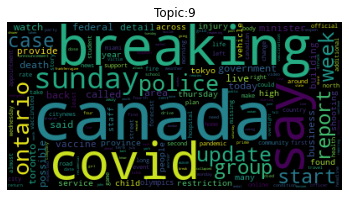

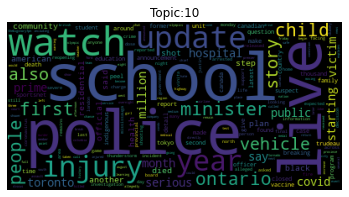

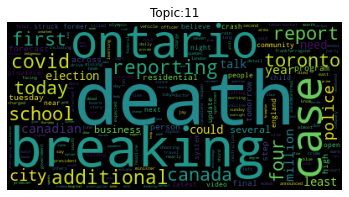

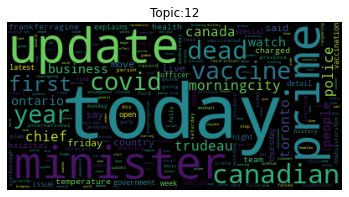

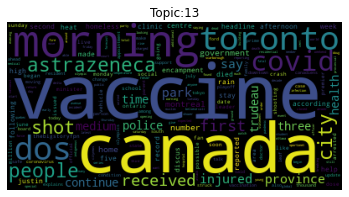

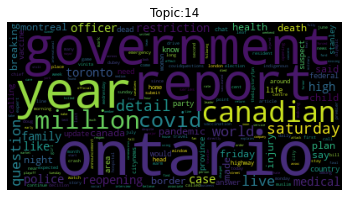

In [19]:
# Generate wordcloud based on the weight or relevance of each keywords
max = 200
for topic in range(lda_model_tfidf.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model_tfidf.show_topic(topic, max))))
    plt.axis("off")
    plt.title("Topic:" + str(topic))
    plt.show()

#### Finding related tweets

In [20]:
import ipywidgets as widgets
from ipywidgets import GridspecLayout, Button
from IPython.display import clear_output

In [21]:
# Define the grid layout of buttons. Values reduced to 5 rows, 6 columns for demo purposes.
grid = GridspecLayout(5,6)
out = widgets.Output()
display(out)

# Function to show the related tweets. Displaying only 5 sample tweets for each topic
def view(button):
    tweets = df_topics[df_topics['Keywords'].str.contains(button.description)]
    tweets.drop(['Topic','Keywords','Contribution'], axis=1, inplace=True)
    word = str.upper(button.description)
    tweets.columns = ([f'TWEETS RELATED TO {word}'])
    tweets = tweets.sample(7)
    left_aligned = tweets.style.set_properties(**{'text-align': 'left'}).hide_index()
    left_aligned = left_aligned.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
    with out:
        clear_output()
        display(left_aligned)

# Loop to display the button with 'Keyword' description. 
# Displaying only 6 Keywords for the first 5 Topics for demo purposes.
for i in range(5): #5 topics
    words = list(dict(lda_model_tfidf.show_topic(i, 6)).keys())
    for j in range(6): #6 keywords
        button = Button(description = words[j], button_style='info', tooltip='click me')
        button.on_click(view)
        grid[i,j] = button       

grid

Output()

GridspecLayout(children=(Button(button_style='info', description='covid', layout=Layout(grid_area='widget001')…